## ML project

### The setup

A former colleague of yours was working on a promising data-focused project, but unfortunately he recently got fired (for unknown reasons), so you are taking the project over. **Your goal** will be to kickstart this project, and turn it into a successful data-driven use case rather than an immature experimental notebook that it is right now. You will have to **improve the approach** started by your colleague, **rethink** some of the more immature techniques, **substantially expand and reinforce** the project, as well as verify that it actually brings business value.

<img src="images/coworker.jpg" width=400>

### Project background

You are working for a bike rental company that hopes to optimize its bicycle availability at various rental locations. You have access to their past data that contains the hourly and daily count of bike rentals between years 2011 and 2012 with the corresponding weather and seasonal information. Our target variable is **cnt** - the number of bikes rented out at a particular moment. Below is a description of the remaining variables:

- **datetime**: date and time when each log of bike rentals was made
- **weathersit**: weather situation at the moment of the log 
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp**: Normalized temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 
- **atemp**: Normalized feeling temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50
- **hum**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **registered**: count of registered users among those who rented bikes
- **cnt**: count of all rental bikes including both unregistered and registered users

**Important assumption**: additional research of the bike rental company showed that each rental location at each moment in time can be considered *independent* of every other bike rental log in the dataset.

The dataset can be seen below:

In [1]:
import pandas as pd

bikes_df = pd.read_csv('data/bike_rentals.csv')
bikes_df.head()

,index,datetime,weathersit,temp,atemp,hum,windspeed,registered,cnt
0,0,2012-05-12 12:00:00,1,0.64,0.6212,0.36,0.1642,353,559
1,1,2012-09-24 18:00:00,1,0.54,0.5152,0.37,0.1642,758,853
2,2,2011-03-10 17:00:00,2,0.44,0.4394,0.00,0.3881,109,111
3,3,2012-08-02 08:00:00,1,0.72,0.6970,0.74,NaN,718,739
4,4,2012-11-10 10:00:00,1,0.40,0.4091,0.58,0.0000,264,350


## The New Project

Here we will try to redevelop this project, while combining all of the concerns about the old project. We will gradually address each part of the project and hopefully end up with a usable application in the end!

*Note:* each block will be turned into a several preprocessing functions which we will later combine together to turn raw data into data ready for ML pipelines

*Note 2:* when creating these preprocessing functions, we should be particularly mindful whether we may further introduce any data leakage into the train-test split as well as whether we may doubt about some preprocessing steps and wish to rather use them as a part of a ML pipeline

## 1. Data Inspection & Quality Concerns

Here we will inspect the quality of the dataset and determine whether there are any serious issues + suggest how we are going to solve them further on

In [2]:
bikes_df.head(3)

,index,datetime,weathersit,temp,atemp,hum,windspeed,registered,cnt
0,0,2012-05-12 12:00:00,1,0.64,0.6212,0.36,0.1642,353,559
1,1,2012-09-24 18:00:00,1,0.54,0.5152,0.37,0.1642,758,853
2,2,2011-03-10 17:00:00,2,0.44,0.4394,0.00,0.3881,109,111


### Preliminary observations 

- index should probably be dropped
- we need to make sure `datetime` is machine readable
- `weathersit` is categorical and therefore needs to be turned into dummy variables
- `temp`, `atemp`, `hum` and `windspeed` could be highly correlated? this may affect some models
- `registered` is a part of cnt => either use it as an alternative target variable or drop it

In [3]:
# missing values

bikes_df.isna().sum()

index            0
datetime         0
weathersit       0
temp           845
atemp            0
hum              0
windspeed     1008
registered       0
cnt              0
dtype: int64

In [4]:
# are missing values random?

(
    bikes_df
    .assign(missing_windspeed = lambda df: df['windspeed'].isna(),
            missing_temp = lambda df: df['temp'].isna())
    .groupby('missing_temp')
    .mean()
)

,index,weathersit,temp,atemp,hum,windspeed,registered,cnt,missing_windspeed
missing_temp,,,,,,,,,
False,8679.507379,1.426576,0.497304,0.476085,0.627171,0.190074,153.959840,189.649147,0.058002
True,8874.740828,1.400000,NaN,0.469715,0.628355,0.192160,150.402367,185.822485,0.057988


In [5]:
(
    bikes_df
    .assign(missing_windspeed = lambda df: df['windspeed'].isna(),
            missing_temp = lambda df: df['temp'].isna())
    .groupby('missing_temp')
    .median()
)

,index,weathersit,temp,atemp,hum,windspeed,registered,cnt,missing_windspeed
missing_temp,,,,,,,,,
False,8672.5,1.0,0.5,0.4848,0.63,0.194,116.0,142.0,0.0
True,8956.0,1.0,NaN,0.4697,0.64,0.194,107.0,132.0,0.0


**conclusion 1:** we might need to consider using an Imputer. Though dropping missing values may not per se be a problem

(For the sake of an exercise) below we create a prep. function that drops missing values
Later an Imputer will be used instead

In [6]:
from functools import wraps
import time

def prep_logger(func):
    """
    a wrapper function that records preprocessed objects' shape changes and the time that preprocessing takes
    """
    @wraps(func)
    def wrapper(*args, **kwargs):
        
        shape_before = args[0].shape
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        shape_after = result.shape
        
        print(f"""{func.__name__} => took: {round(end_time - start_time, 2)} seconds;
               shape before: {shape_before}
               shape after:  {shape_after}""")
        
        return result
    
    return wrapper

In [7]:
@prep_logger
def remove_nans(dataf):
    
    """ drops missing values from a dataframe """
    
    return dataf.dropna()

In [8]:
# test of remove_nans

(
    bikes_df
    .sample(100)
    .pipe(remove_nans)
    .head(2)
)

remove_nans => took: 0.0 seconds;
               shape before: (100, 9)
               shape after:  (97, 9)


,index,datetime,weathersit,temp,atemp,hum,windspeed,registered,cnt
11832,11832,2011-03-05 06:00:00,2,0.30,0.2879,1.00,0.2239,3,4
5220,5220,2012-10-22 09:00:00,1,0.46,0.4545,0.63,0.0896,335,360


**up next:** we check target variable distribution to consider dropping any outliers

In [9]:
# target variable distribution

bikes_df[['cnt']].describe()

,cnt
count,17379.000000
mean,189.463088
std,181.387599
min,1.000000
25%,40.000000
50%,142.000000
75%,281.000000
max,977.000000


In [10]:
bikes_df[['cnt']].quantile(0.95)

cnt    563.1
Name: 0.95, dtype: float64

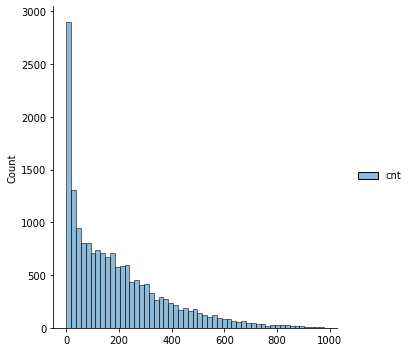

In [11]:
import seaborn as sns

sns.displot(bikes_df[['cnt']]);

### preliminary conclusions

- maybe consider a log-transform of the target?
- no clear isolated outliers 


**up next:** solve any remaining issues with the input data:

In [12]:
bikes_df.head()

,index,datetime,weathersit,temp,atemp,hum,windspeed,registered,cnt
0,0,2012-05-12 12:00:00,1,0.64,0.6212,0.36,0.1642,353,559
1,1,2012-09-24 18:00:00,1,0.54,0.5152,0.37,0.1642,758,853
2,2,2011-03-10 17:00:00,2,0.44,0.4394,0.00,0.3881,109,111
3,3,2012-08-02 08:00:00,1,0.72,0.6970,0.74,NaN,718,739
4,4,2012-11-10 10:00:00,1,0.40,0.4091,0.58,0.0000,264,350


In [13]:
@prep_logger
def remove_columns(dataf, cols = []):
    
    """ drops given columns """
    
    return dataf.drop(columns = cols)


@prep_logger
def adjust_col_names(dataf):
    
    """ makes all column names lowercase with underscores instead of spaces """
    
    return dataf.rename(lambda x: x.lower().replace(" ","_"), axis='columns')


@prep_logger
def remove_outliers(dataf, outlier_precentile = 0.05):
    
    """ removes outliers below `outlier_precentile` or above 1 - this value """
    
    return (
        
        dataf
        .loc[lambda df: ~((df < df.quantile(outlier_precentile)) |
                          (df > df.quantile(1 - outlier_precentile))).any(axis = 1)]
    )

In [14]:
# testing the above functions

cleaned_bike_df = (
    
    bikes_df
    .pipe(remove_columns, cols = ['index', 'registered'])
    .pipe(adjust_col_names)
    #.pipe(remove_nans)
    #.pipe(remove_outliers, outlier_precentile = 0.01)
    #.pipe(prep_logger(pd.get_dummies), columns = ['weathersit'], drop_first = True)
    .reset_index(drop = True)
    
)

cleaned_bike_df.head(2)

remove_columns => took: 0.0 seconds;
               shape before: (17379, 9)
               shape after:  (17379, 7)
adjust_col_names => took: 0.0 seconds;
               shape before: (17379, 7)
               shape after:  (17379, 7)


,datetime,weathersit,temp,atemp,hum,windspeed,cnt
0,2012-05-12 12:00:00,1,0.64,0.6212,0.36,0.1642,559
1,2012-09-24 18:00:00,1,0.54,0.5152,0.37,0.1642,853


## 2. Feature Engineering

Here we will use our domain knowledge determine which useful features can be extracted manually, and which ones can be added using some automatic feature generators

### Why and how?

Feature engineering is a way to isolate and highlight key information that may be hiding in some features or based on your own domain knowledge, which helps ML algorithms focus on what is actually important. Here is an overview of some popular types of feature engineering:

* **Date and time features**: Creating features from the dates available, e.g. is a holidays or day of the week. 
* **Group values**: Grouping various numeric elements to a categorical variable, e.g. the months December (12), January (1) and February (2) to the season Winter. 
* **Grouping sparse classes**: If you have a feature with an individual low sample count, you might group various values together under some other category. For example: in the full Titanic dataset, there is a column 'Title' with mrs, ms, miss and various other titles such as jonkheer, countess, major, lady, captain. These last few titles are usually grouped together under a single 'Other' category.
* **Group from threshold**: A new grouped variable for other variables, e.g. 'warm' and 'cold' based on the temperature.
* **Indicator from threshold**: An indicator variable (0 or 1) based on a threshold on a column, e.g. eligible to vote based on age. 
* **Interaction of variables**: The sum, difference, product or quotient of two features. E.g. `profit` as result of the difference between income and expenses. 

Below we focus on extracting information from the `datetime` feature

In [15]:
@prep_logger
def add_time_features(df, date_column = 'datetime'):
    
    """ Preprocessing function
    Adjusts `date` column's format to be datetime.
    Then extracts year, month, day, hour columns.
    """
    
    return (
        df
        .assign(datetime = lambda df: pd.to_datetime(df[date_column]),
                year = lambda df: df['datetime'].apply(lambda x: x.year), #can also be done with .dt.year
                month = lambda df: df['datetime'].dt.month,
                day = lambda df: df['datetime'].dt.day,
                hour = lambda df: df['datetime'].dt.hour
               )
    )

In [16]:
# test of remove_nans

extended_bike_df = (
    cleaned_bike_df
    .pipe(add_time_features)
)

extended_bike_df.head(2)

add_time_features => took: 0.05 seconds;
               shape before: (17379, 7)
               shape after:  (17379, 11)


,datetime,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour
0,2012-05-12 12:00:00,1,0.64,0.6212,0.36,0.1642,559,2012,5,12,12
1,2012-09-24 18:00:00,1,0.54,0.5152,0.37,0.1642,853,2012,9,24,18


## 3. ML applicability

Here we will explore and justify whether this problem and the available data actually allow us to use a ML approach. This would not be the case in two situations:

- The problem is too simple (there are features ~99% correlated with the target)
- The problem is too complex & there is not enough information (the features are rather unrelated to the problem)

In [17]:
extended_bike_df.corr()

,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour
weathersit,1.000000,-0.103486,-0.105563,0.418130,0.022753,-0.142426,-0.019157,0.005400,-0.003882,-0.020203
temp,-0.103486,1.000000,0.987732,-0.071211,-0.024726,0.402391,0.040616,0.199928,0.027915,0.137657
atemp,-0.105563,0.987732,1.000000,-0.051918,-0.065106,0.400929,0.039222,0.208096,0.021269,0.133750
hum,0.418130,-0.071211,-0.051918,1.000000,-0.292738,-0.322911,-0.083546,0.164411,0.025663,-0.276498
windspeed,0.022753,-0.024726,-0.065106,-0.292738,1.000000,0.092615,-0.008921,-0.134440,0.010531,0.138271
cnt,-0.142426,0.402391,0.400929,-0.322911,0.092615,1.000000,0.250495,0.120638,-0.004312,0.394071
year,-0.019157,0.040616,0.039222,-0.083546,-0.008921,0.250495,1.000000,-0.010473,0.002057,-0.003867
month,0.005400,0.199928,0.208096,0.164411,-0.134440,0.120638,-0.010473,1.000000,0.007929,-0.005772
day,-0.003882,0.027915,0.021269,0.025663,0.010531,-0.004312,0.002057,0.007929,1.000000,0.001538
hour,-0.020203,0.137657,0.133750,-0.276498,0.138271,0.394071,-0.003867,-0.005772,0.001538,1.000000


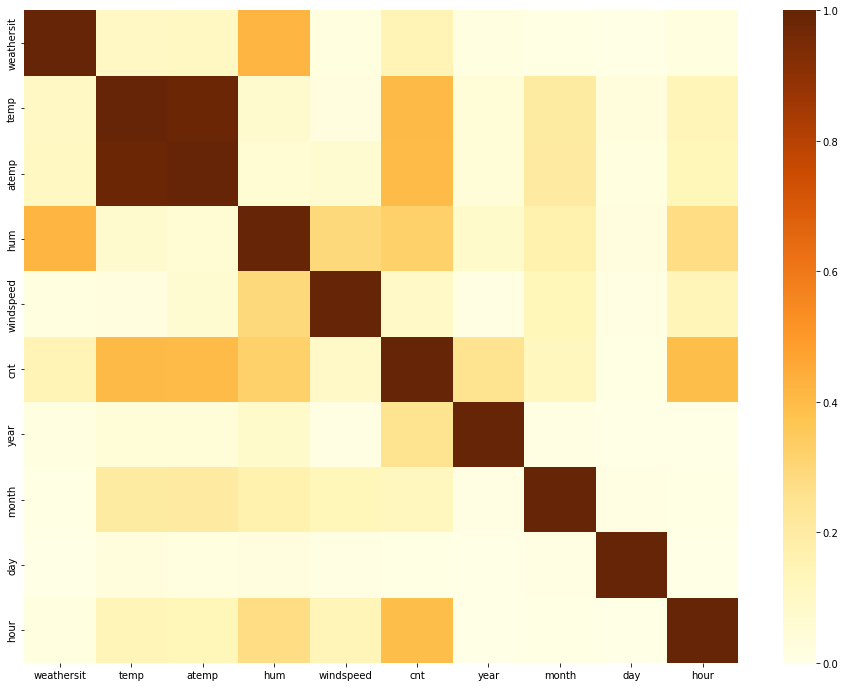

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (16,12))
sns.heatmap(extended_bike_df.corr().abs(), ax = ax, vmin = 0, cmap = sns.color_palette("YlOrBr", as_cmap=True));

**preliminary conclusions** there are no columns that seem to be able to perfectly predict `cnt`, while there is noticeable correlation with some features 

## 4. Building a preprocessing ML pipeline

Here we will focus on assembling any preprocessing blocks of a ML pipeline that we are going to use in combination with a ML model later

## 5. Choosing and setting up ML model(s)

Here we will decide on which ML models may be a good choice for us in this application, and set them up

## 6. Parameter Tuning

Here we will select the best parameters for each model

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

In [20]:
y = extended_bike_df['cnt']
X = extended_bike_df.drop(columns=['cnt', 'datetime'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [21]:
X.head()

,weathersit,temp,atemp,hum,windspeed,year,month,day,hour
0,1,0.64,0.6212,0.36,0.1642,2012,5,12,12
1,1,0.54,0.5152,0.37,0.1642,2012,9,24,18
2,2,0.44,0.4394,0.00,0.3881,2011,3,10,17
3,1,0.72,0.6970,0.74,NaN,2012,8,2,8
4,1,0.40,0.4091,0.58,0.0000,2012,11,10,10


In [22]:
X.columns

Index(['weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'year', 'month',
       'day', 'hour'],
      dtype='object')

In [23]:
cat_prep = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))])

num_prep = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])

ct = ColumnTransformer(
    [
    ("cat_prep", cat_prep, ['weathersit', 'year', 'month', 'hour']),
    ("num_prep", num_prep, ['temp', 'atemp', 'hum', 'windspeed', 'day']),
    ], remainder = 'drop') 

In [24]:
bike_pipeline = Pipeline(steps=[
    ('scale-encode', ct),
    ('PFeatures', PolynomialFeatures()),
    ('feature_selection', SelectFromModel(Lasso(alpha = 0.05))),
    ('model', RandomForestClassifier())])

bike_pipeline.fit(X_train, y_train);

## further plan

While this example solution stops here, below are some guidelines to successfully complete and improve this project

- Use CV scores (e.g. r2 score) to get an idea whether the current pipeline makes sense and get a glimpse of which parameters to tune during grid search
- use grid search to find the best parameters. Make sure to try different metrics and inspect 2 and 3d best models
- Try other ML models, which ones make a good comparison to the one above?
- Save the chosen "best" pipeline on disk
- save the created Pandas prep functions in a separate py file(s) 
- Optional: Use the two above to generate a predictive app with streamlit using the template from `ml_project_package\bike_demand_app\app.py`